# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# 2. Data Loading and Preliminary Processing

The first thing we do load our data and take a first peek at it.

In [2]:
#Load data
file_path = '/kaggle/input/covid19/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx'
data = pd.read_excel(file_path)
data.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


This data is set up in a very specific way.  For each patient, as defined in the PATIENT_VISIT_IDENTIFIER feature, the entries represent different stages of the patient since its admission into the hospital. Lets take a look at how many entries are there for each patient.

In [3]:
#Compute number of entries per patient
data.groupby(by = 'PATIENT_VISIT_IDENTIFIER').count()['ICU'].sort_values(ascending = False)

PATIENT_VISIT_IDENTIFIER
384    5
191    5
121    5
122    5
123    5
      ..
258    5
259    5
260    5
261    5
0      5
Name: ICU, Length: 385, dtype: int64

As we can see, all patients in this dataset have the same amount of entries. However, as instructed, the data in which the patients have already been moved to the ICU are not to be used. But we are not discarding this data yet. What we are going to do first is to extract two very important information from the the data as it is:

* Which patients are admitted to the UCI;
* At which point these patients are admitted to the UCI.

In [4]:
#Define function to compilate the ICU admission data
def ICU_admission(data):
    admission_data = data.groupby(
        by = 'PATIENT_VISIT_IDENTIFIER', 
        as_index = False).max()[['PATIENT_VISIT_IDENTIFIER', 'ICU']]
    
    admission_time_data = data.groupby(by = ['PATIENT_VISIT_IDENTIFIER', 'ICU'],
                                       as_index = False).first()[['PATIENT_VISIT_IDENTIFIER', 'ICU', 'WINDOW']]
    
    admission_data = admission_data.join(
        other = admission_time_data[admission_time_data['ICU'] == 1].set_index('PATIENT_VISIT_IDENTIFIER'),
        on = 'PATIENT_VISIT_IDENTIFIER',
        how = 'left',
        rsuffix = '_R')
    
    return admission_data.drop(columns = 'ICU_R')

In [5]:
#Get admission compiled data
admission_data = ICU_admission(data)
print(admission_data)

     PATIENT_VISIT_IDENTIFIER  ICU    WINDOW
0                           0    1  ABOVE_12
1                           1    1       0-2
2                           2    1  ABOVE_12
3                           3    0       NaN
4                           4    0       NaN
..                        ...  ...       ...
380                       380    1  ABOVE_12
381                       381    0       NaN
382                       382    1  ABOVE_12
383                       383    0       NaN
384                       384    0       NaN

[385 rows x 3 columns]


Now, we are going to rearrange the patient information into a more time series like format.

In [6]:
#Define function to rearrange the data
admission_window_order = {
    '0-2': 1,
    '2-4': 2,''
    '4-6': 3,
    '6-12': 4,
    'ABOVE_12': 5}

def to_timeseries_format(data, position_dict):
    
    #Order dictionary
    position_dict = sorted(position_dict.items())
    
    #Split data
    df_list = []
    for position in position_dict:
        value, pos = position
        suffix = '_' + str(pos)
        df_list.append(data[data['WINDOW'] == value].add_suffix(suffix).reset_index(drop = True))
        
    #Reassemble data
    output_data = pd.concat(df_list, axis = 1)
    return output_data


In [7]:
#Rearrange data into time series format
data = to_timeseries_format(data, admission_window_order)
data = data.drop(columns = ['PATIENT_VISIT_IDENTIFIER_2', 'PATIENT_VISIT_IDENTIFIER_3',
                            'PATIENT_VISIT_IDENTIFIER_4', 'PATIENT_VISIT_IDENTIFIER_5'])
data.head()

,PATIENT_VISIT_IDENTIFIER_1,AGE_ABOVE65_1,AGE_PERCENTIL_1,GENDER_1,DISEASE GROUPING 1_1,DISEASE GROUPING 2_1,DISEASE GROUPING 3_1,DISEASE GROUPING 4_1,DISEASE GROUPING 5_1,DISEASE GROUPING 6_1,...,TEMPERATURE_DIFF_5,OXYGEN_SATURATION_DIFF_5,BLOODPRESSURE_DIASTOLIC_DIFF_REL_5,BLOODPRESSURE_SISTOLIC_DIFF_REL_5,HEART_RATE_DIFF_REL_5,RESPIRATORY_RATE_DIFF_REL_5,TEMPERATURE_DIFF_REL_5,OXYGEN_SATURATION_DIFF_REL_5,WINDOW_5,ICU_5
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1
1,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.142857,-0.797980,0.315690,0.200359,-0.239515,0.645161,0.139709,-0.802317,ABOVE_12,1
2,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.500000,-0.898990,-0.612422,-0.343258,-0.576744,-0.695341,-0.505464,-0.900129,ABOVE_12,1
3,3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.047619,-0.171717,-0.308696,-0.057718,-0.069094,-0.329749,-0.047619,-0.172436,ABOVE_12,0
4,4,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.642857,-0.939394,-0.652174,-0.596165,-0.634847,-0.817204,-0.645793,-0.940077,ABOVE_12,0


We are on step closer to finishing the data preprocessing. In order to reduce our dataset, we are now going to remove the redudant variables. We are talking about features that will not change for a given patient, such as *AGE_PERCENTIL* and *GENDER*.

In [8]:
#Define function to remove redudant columns
def remove_redudant_cols(data, cols, range_begin, range_end):
    for n in range(range_begin, range_end+1):
        rm_cols = [x + '_'  + str(n) for x in cols]
        data = data.drop(columns = rm_cols)
        
    return data

In [9]:
#Remove redudant columns
redudant_cols = ['AGE_ABOVE65', 'AGE_PERCENTIL', 'GENDER', 'HTN', 'WINDOW']
data = remove_redudant_cols(data, redudant_cols, 2, 5).drop(columns = 'WINDOW_1')

# 3. Data Cleaning and Processing

In this section, we are basically going to do two things:

1. Handle missing values;
2. Reduce our 

## 3.1. Missing Values

In [10]:
#Identify features with missing values as a percentage of the total number of records
null_values = data.isnull().sum()
null_values = 100 * null_values[null_values > 0] / len(data)

null_values.sort_values(ascending = False)

P02_VENOUS_MAX_3        89.090909
PLATELETS_MAX_3         89.090909
PC02_VENOUS_MAX_3       89.090909
PC02_VENOUS_DIFF_3      89.090909
PCR_MEDIAN_3            89.090909
                          ...    
DISEASE GROUPING 4_5     0.259740
DISEASE GROUPING 5_5     0.259740
DISEASE GROUPING 6_5     0.259740
IMMUNOCOMPROMISED_5      0.259740
DISEASE GROUPING 1_1     0.259740
Length: 1121, dtype: float64

As we can see, while some features present almost no missing values, some are nearly entirely made up of *nulls*. However, we should not be quick to discard this data, since there is a time element to these attributes.

In [11]:
over_50pct_nulls = null_values[null_values > 50]
print(over_50pct_nulls.sort_index())

ALBUMIN_DIFF_1    55.324675
ALBUMIN_DIFF_2    54.025974
ALBUMIN_DIFF_3    89.090909
ALBUMIN_DIFF_4    85.454545
ALBUMIN_MAX_1     55.324675
                    ...    
UREA_MEDIAN_4     85.454545
UREA_MIN_1        55.324675
UREA_MIN_2        54.025974
UREA_MIN_3        89.090909
UREA_MIN_4        85.454545
Length: 792, dtype: float64


In [12]:
#Identifying which feature groups are mostly composed of missing values
over_50pct_nulls = over_50pct_nulls.reset_index(level = 0).rename(columns = {'index': 'Feature', 0: 'Null_Pct'})
over_50pct_nulls['Feature_Group'] = [x[:-2] for x in over_50pct_nulls['Feature']]

null_aggregate = over_50pct_nulls.groupby(by = 'Feature_Group').agg({'Null_Pct': ['count', 'min', 'max']})
print(null_aggregate)

               Null_Pct                      
                  count        min        max
Feature_Group                                
ALBUMIN_DIFF          4  54.025974  89.090909
ALBUMIN_MAX           4  54.025974  89.090909
ALBUMIN_MEAN          4  54.025974  89.090909
ALBUMIN_MEDIAN        4  54.025974  89.090909
ALBUMIN_MIN           4  54.025974  89.090909
...                 ...        ...        ...
UREA_DIFF             4  54.025974  89.090909
UREA_MAX              4  54.025974  89.090909
UREA_MEAN             4  54.025974  89.090909
UREA_MEDIAN           4  54.025974  89.090909
UREA_MIN              4  54.025974  89.090909

[216 rows x 3 columns]


In [13]:
null_aggregate.columns = ['_'.join(col).strip() for col in null_aggregate.columns.values]
null_aggregate.query('Null_Pct_count == 4 & Null_Pct_min > 50')

,Null_Pct_count,Null_Pct_min,Null_Pct_max
Feature_Group,,,
ALBUMIN_DIFF,4,54.025974,89.090909
ALBUMIN_MAX,4,54.025974,89.090909
ALBUMIN_MEAN,4,54.025974,89.090909
ALBUMIN_MEDIAN,4,54.025974,89.090909
ALBUMIN_MIN,4,54.025974,89.090909
...,...,...,...
UREA_DIFF,4,54.025974,89.090909
UREA_MAX,4,54.025974,89.090909
UREA_MEAN,4,54.025974,89.090909


These results show a total of 180 feature groups have more nulls than actual values. Our first approach will simply be to remove the related features.

In [14]:
#Remove columns with overrepresentation of null values
over_50pct_nulls = null_aggregate.query('Null_Pct_count == 4 & Null_Pct_min > 50').index

for n in range(1,6):
    remove_cols = [x + '_' + str(n) for x in over_50pct_nulls]
    data = data.drop(columns = remove_cols)
    
data.head()

,PATIENT_VISIT_IDENTIFIER_1,AGE_ABOVE65_1,AGE_PERCENTIL_1,GENDER_1,DISEASE GROUPING 1_1,DISEASE GROUPING 2_1,DISEASE GROUPING 3_1,DISEASE GROUPING 4_1,DISEASE GROUPING 5_1,DISEASE GROUPING 6_1,...,RESPIRATORY_RATE_DIFF_5,TEMPERATURE_DIFF_5,OXYGEN_SATURATION_DIFF_5,BLOODPRESSURE_DIASTOLIC_DIFF_REL_5,BLOODPRESSURE_SISTOLIC_DIFF_REL_5,HEART_RATE_DIFF_REL_5,RESPIRATORY_RATE_DIFF_REL_5,TEMPERATURE_DIFF_REL_5,OXYGEN_SATURATION_DIFF_REL_5,ICU_5
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.176471,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,1
1,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.764706,0.142857,-0.797980,0.315690,0.200359,-0.239515,0.645161,0.139709,-0.802317,1
2,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.705882,-0.500000,-0.898990,-0.612422,-0.343258,-0.576744,-0.695341,-0.505464,-0.900129,1
3,3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.352941,-0.047619,-0.171717,-0.308696,-0.057718,-0.069094,-0.329749,-0.047619,-0.172436,0
4,4,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.823529,-0.642857,-0.939394,-0.652174,-0.596165,-0.634847,-0.817204,-0.645793,-0.940077,0


Our dataset was reduced from the previous 1131 to 251 columns. There surely a lot of information we are discarding in this process. However, we should not worry. We can always come back at look at this features again.

Focusing on the remaining attributes, let's take a look at how to handle their missing values.

In [15]:
null_values = data.isnull().sum()
null_values = 100 * null_values[null_values > 0] / len(data)

null_values.sort_index()

BLOODPRESSURE_DIASTOLIC_DIFF_1    64.415584
BLOODPRESSURE_DIASTOLIC_DIFF_2    54.025974
BLOODPRESSURE_DIASTOLIC_DIFF_3    43.636364
BLOODPRESSURE_DIASTOLIC_DIFF_4    15.584416
BLOODPRESSURE_DIASTOLIC_DIFF_5     0.259740
                                    ...    
TEMPERATURE_MIN_1                 68.311688
TEMPERATURE_MIN_2                 55.844156
TEMPERATURE_MIN_3                 43.896104
TEMPERATURE_MIN_4                 11.948052
TEMPERATURE_MIN_5                  0.259740
Length: 221, dtype: float64

A very interesting pattern seems to arise from the missing value percentage computed data. It appears there are missing values on the early stages of admission to the hospital which gradually reduce to nearly zero at the last measurement window. This probably due to the fact that, not all measurements are taken early in the admission.

This leads us to the first approach we are going to take on filling the missing values. Basically, the assumption is measurements start to be taken when the patient has just started to present some change on his or hers clinical condition. Therefore, we assume the previous null values could be filled with the first non null value for a given patient.

In [16]:
#Split columns into time variant or patient constant
col_groups = np.unique([x[:-2] for x in data.columns.values], return_counts = True)
time_cols = [col_groups[0][x] for x in range(len(col_groups[0])) if col_groups[1][x] > 1]
constant_cols = [x + '_1' for x in col_groups[0] if x not in time_cols]

In [17]:
#Define function to fill the missing values on the time variant features
def fill_missing_values(data, time_group, const_group):
    
    group_df = [data[const_group]]
    for group in time_group:
        col_names = [group + '_' + str(x) for x in range(1, 6)]
        group_df.append(data[col_names].fillna(method = 'backfill', axis = 1).reset_index(drop = True))
    
    return pd.concat(group_df, axis = 1)

In [18]:
#Fill missing values
data = fill_missing_values(data, time_cols, constant_cols)

null_values = data.isnull().sum()
null_values[null_values > 0].sort_values(ascending = False)

TEMPERATURE_MIN_5               1
DISEASE GROUPING 2_3            1
DISEASE GROUPING 4_4            1
DISEASE GROUPING 4_3            1
DISEASE GROUPING 4_2            1
                               ..
OXYGEN_SATURATION_MAX_3         1
OXYGEN_SATURATION_MAX_2         1
OXYGEN_SATURATION_MAX_1         1
OXYGEN_SATURATION_DIFF_REL_5    1
HTN_1                           1
Length: 221, dtype: int64

After applying our approach for the missing values, there are still a single null for most of the features. This is likely a single record with nearly no information. Let's confirm that.

In [19]:
#Check which rows still have missing values
null_values = data.isnull().sum(axis = 1)
null_rows = null_values[null_values > 0].index.values

print(null_rows)

[199]


This confirms our suspicion. Since we are talking about a single records, let's just discard it.

In [20]:
#Remove remaining missing values
data = data.drop(index = null_rows)

## 3.2. Remove Data Where *ICU = 1*

Lets have a look at our data set again, to see how it looks like after all this preprocessing.

In [21]:
data.head()

,AGE_ABOVE65_1,AGE_PERCENTIL_1,GENDER_1,HTN_1,PATIENT_VISIT_IDENTIFIER_1,BLOODPRESSURE_DIASTOLIC_DIFF_1,BLOODPRESSURE_DIASTOLIC_DIFF_2,BLOODPRESSURE_DIASTOLIC_DIFF_3,BLOODPRESSURE_DIASTOLIC_DIFF_4,BLOODPRESSURE_DIASTOLIC_DIFF_5,...,TEMPERATURE_MEDIAN_1,TEMPERATURE_MEDIAN_2,TEMPERATURE_MEDIAN_3,TEMPERATURE_MEDIAN_4,TEMPERATURE_MEDIAN_5,TEMPERATURE_MIN_1,TEMPERATURE_MIN_2,TEMPERATURE_MIN_3,TEMPERATURE_MIN_4,TEMPERATURE_MIN_5
0,1,60th,0,0.0,0,-1.000000,-1.000000,-0.339130,-0.339130,-0.339130,...,-0.285714,0.535714,-0.107143,-0.107143,0.035714,0.208791,0.714286,0.318681,0.318681,0.098901
1,1,90th,1,1.0,1,-1.000000,-1.000000,-1.000000,-0.913043,0.513043,...,-0.107143,-0.107143,-0.035714,0.142857,0.000000,0.318681,0.318681,0.362637,0.406593,0.010989
2,0,10th,0,0.0,2,-0.547826,-0.547826,-0.547826,-0.704348,-0.547826,...,0.357143,0.357143,0.357143,0.357143,0.107143,0.604396,0.604396,0.604396,0.604396,0.142857
3,0,40th,1,0.0,3,-1.000000,-1.000000,-1.000000,-1.000000,-0.078261,...,-0.285714,-0.285714,-0.285714,-0.107143,-0.035714,0.208791,0.208791,0.208791,0.318681,0.120879
4,0,10th,0,0.0,4,-1.000000,-1.000000,-1.000000,-1.000000,-0.478261,...,0.285714,0.285714,0.285714,0.321429,0.071429,0.538462,0.538462,0.538462,0.340659,0.208791


We want to explore the dataset, but before, there's a small matter we need to resolve. As we trying to create a model to predict whether or not a patient will require ICU care. Therefore, as instructed by the dataset providers, the data gathered after the ICU admission should not be taken into consideration. Since we are not going to use this data to model ICU admission, it does not make sense to explore this data. Let's them proceed to removing this data.

In [22]:
#Define function to remove data measured after ICU admission
def remove_ICU_data(data):
    
    df_list = []
    for n in range(1, 6):
        cols = [x for x in data.columns.values if int(x[-1]) == n]
        ICU_col = 'ICU_' + str(n)
        df_list.append(data[data[ICU_col] == 0][cols].drop(columns = ICU_col))
        
    return pd.concat(df_list, axis = 1)

In [23]:
#Remove data after ICU admission
data = remove_ICU_data(data)

Let's now have another look at our data.

In [24]:
data

,AGE_ABOVE65_1,AGE_PERCENTIL_1,GENDER_1,HTN_1,PATIENT_VISIT_IDENTIFIER_1,BLOODPRESSURE_DIASTOLIC_DIFF_1,BLOODPRESSURE_DIASTOLIC_DIFF_REL_1,BLOODPRESSURE_DIASTOLIC_MAX_1,BLOODPRESSURE_DIASTOLIC_MEAN_1,BLOODPRESSURE_DIASTOLIC_MEDIAN_1,...,RESPIRATORY_RATE_MAX_5,RESPIRATORY_RATE_MEAN_5,RESPIRATORY_RATE_MEDIAN_5,RESPIRATORY_RATE_MIN_5,TEMPERATURE_DIFF_5,TEMPERATURE_DIFF_REL_5,TEMPERATURE_MAX_5,TEMPERATURE_MEAN_5,TEMPERATURE_MEDIAN_5,TEMPERATURE_MIN_5
0,1,60th,0,0.0,0,-1.000000,-1.000000,-0.247863,0.086420,0.086420,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,10th,0,0.0,2,-0.547826,-0.515528,-0.435897,-0.489712,-0.506173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,40th,1,0.0,3,-1.000000,-1.000000,-0.299145,0.012346,0.012346,...,-0.272727,-0.535593,-0.517241,-0.857143,-0.047619,-0.047619,0.623188,0.033571,-0.035714,0.120879
4,0,10th,0,0.0,4,-1.000000,-1.000000,-0.076923,0.333333,0.333333,...,-0.454545,-0.499708,-0.517241,-0.500000,-0.642857,-0.645793,0.014493,0.040640,0.071429,0.208791
5,0,10th,0,0.0,5,-0.826087,-0.860870,-0.247863,-0.037037,-0.037037,...,-0.515152,-0.502825,-0.517241,-0.428571,-0.738095,-0.736640,-0.130435,-0.109127,-0.107143,0.186813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,0,40th,1,0.0,380,-1.000000,-1.000000,-0.418803,-0.160494,-0.160494,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
381,1,Above 90th,0,0.0,381,-1.000000,-1.000000,-0.589744,-0.407407,-0.407407,...,-0.575758,-0.570621,-0.517241,-0.571429,-0.690476,-0.697169,0.188406,0.238095,0.250000,0.384615
382,0,50th,0,0.0,382,-1.000000,-1.000000,-0.299145,0.012346,0.012346,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
383,0,40th,1,0.0,383,-1.000000,-1.000000,-0.247863,0.086420,0.086420,...,-0.393939,-0.541009,-0.517241,-0.714286,-0.571429,-0.572609,0.043478,0.036125,0.000000,0.164835


Two interesting things happened here. The first, the reduction on the number of columns, is very easy to explain. In our function, the *ICU* attributes are removed, result in precisely 5 fewer columns. The reduced amount of records on the other hand, indicates some patients were directly addmited to the ICU. Their data is of no use for the task we are trying to acomplish, so it was removed.

## 3.3. Consolidate Data

At the beggining of this notebook, one of the thing we did was compile the admission data to indetify whether each patient eventually required ICU treatment. Since our data is already on the format we intend to use, now it's a good time to put it all together.

In [25]:
#Join data together
data = data.join(other = admission_data.set_index('PATIENT_VISIT_IDENTIFIER').drop(columns = 'WINDOW'),
                 on = 'PATIENT_VISIT_IDENTIFIER_1',
                 how = 'inner')

data.head()

,AGE_ABOVE65_1,AGE_PERCENTIL_1,GENDER_1,HTN_1,PATIENT_VISIT_IDENTIFIER_1,BLOODPRESSURE_DIASTOLIC_DIFF_1,BLOODPRESSURE_DIASTOLIC_DIFF_REL_1,BLOODPRESSURE_DIASTOLIC_MAX_1,BLOODPRESSURE_DIASTOLIC_MEAN_1,BLOODPRESSURE_DIASTOLIC_MEDIAN_1,...,RESPIRATORY_RATE_MEAN_5,RESPIRATORY_RATE_MEDIAN_5,RESPIRATORY_RATE_MIN_5,TEMPERATURE_DIFF_5,TEMPERATURE_DIFF_REL_5,TEMPERATURE_MAX_5,TEMPERATURE_MEAN_5,TEMPERATURE_MEDIAN_5,TEMPERATURE_MIN_5,ICU
0,1,60th,0,0.0,0,-1.000000,-1.000000,-0.247863,0.086420,0.086420,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,0,10th,0,0.0,2,-0.547826,-0.515528,-0.435897,-0.489712,-0.506173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,0,40th,1,0.0,3,-1.000000,-1.000000,-0.299145,0.012346,0.012346,...,-0.535593,-0.517241,-0.857143,-0.047619,-0.047619,0.623188,0.033571,-0.035714,0.120879,0
4,0,10th,0,0.0,4,-1.000000,-1.000000,-0.076923,0.333333,0.333333,...,-0.499708,-0.517241,-0.500000,-0.642857,-0.645793,0.014493,0.040640,0.071429,0.208791,0
5,0,10th,0,0.0,5,-0.826087,-0.860870,-0.247863,-0.037037,-0.037037,...,-0.502825,-0.517241,-0.428571,-0.738095,-0.736640,-0.130435,-0.109127,-0.107143,0.186813,0


# 4. Data Exploration

Now, after all this work, we are going to, yet again, look at our dataset. But, this time, we are going to plot some graphs and try to see how these features behave isolated and with each other.

## 4.1. Patient-Constant Features

In [26]:
#Identify patient-constant features
col_groups = [x[:-2] for x in data.drop(columns = ['PATIENT_VISIT_IDENTIFIER_1', 'ICU']).columns.values]
col_groups = np.unique(col_groups , return_counts = True)

patient_constant_cols = [col_groups[0][x] for x in range(len(col_groups[0])) if col_groups[1][x] == 1]
patient_constant_cols

['AGE_ABOVE65', 'AGE_PERCENTIL', 'GENDER', 'HTN']

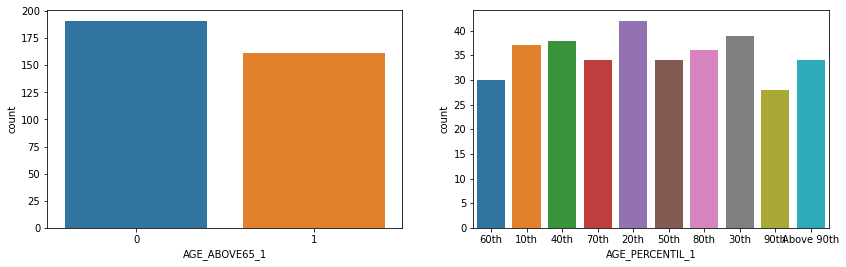

In [27]:
#AGE_ABOVE65 and AGE_PERCENTIL
fig, axis = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 4))
sns.countplot(data['AGE_ABOVE65_1'], ax = axis[0])
sns.countplot(data['AGE_PERCENTIL_1'], ax = axis[1])
plt.show(fig)

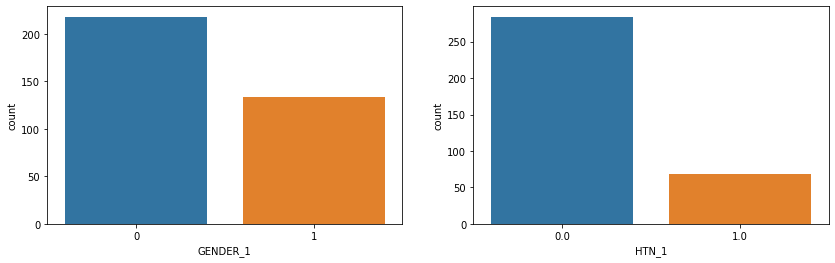

In [28]:
#GENDER and HTN
fig, axis = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 4))
sns.countplot(data['GENDER_1'], ax = axis[0])
sns.countplot(data['HTN_1'], ax = axis[1])
plt.show(fig)

For these features, all but *HTN* are fairly well distributed. Let's not take a look at how they relate directly to the target.

In [29]:
#Define function for a normalized staked bars plot
def normalized_stacked_bars(data, col, target):

    bottom = [0 for x in data[col].unique()]
    for cls in data[target].unique():
        x_vals, y_vals = np.unique(data[data[target] == cls][col], return_counts = True)
        x_vals = [str(x) for x in x_vals] 
        y_vals = [x / y for x, y in zip(y_vals, np.unique(data[col], return_counts = True)[1])]
        
        plt.bar(x_vals, y_vals, bottom = bottom, color = np.random.rand(1,3))
        bottom = [x + y for x, y in zip(bottom, y_vals)]
    
    plt.legend(np.unique(data[target]), title = target)
    plt.title(col)
    
    return plt.show()

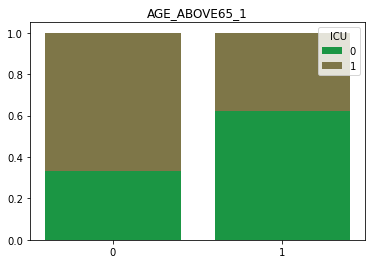

In [30]:
#AGE_ABOVE65
normalized_stacked_bars(data, 'AGE_ABOVE65_1', 'ICU')

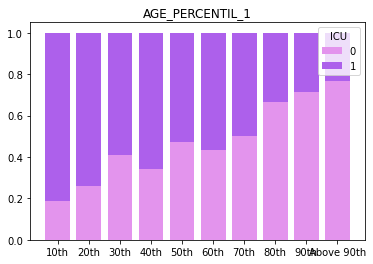

In [31]:
#AGE_PERCENTIL
normalized_stacked_bars(data, 'AGE_PERCENTIL_1', 'ICU')

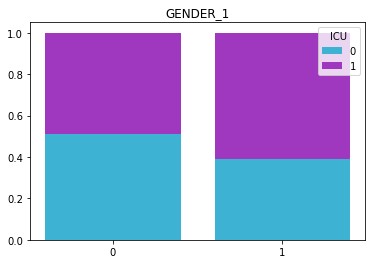

In [32]:
#GENDER
normalized_stacked_bars(data, 'GENDER_1', 'ICU')

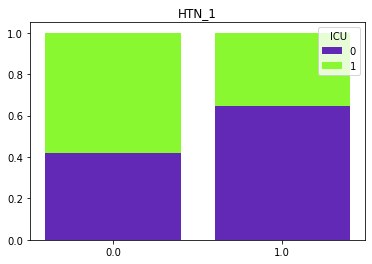

In [33]:
#HTN
normalized_stacked_bars(data, 'HTN_1', 'ICU')

For *AGE_ABOVE65*, *GENDER* and *HTN* we see there is clearly some relationship between the features and the target. For *AGE_PERCENTIL*, we can see an indication of strong correlation.

## 4.2. Time-Variant Features

Now let's take a look at the features that change over time. For that, we are going to take two approaches. First, we are going to investigate each measurement regardless of when it was taken. Following, we are going to look at theses features as in a time series.

### 4.2.1. First Approach: Investigate Entire Feature Groups

Here, we are are going to try and simplify our analysis. There are a lot of features, and even if we adopt the group approach, there is still a large number of groups for us to look at then individually. One way out of this comes from the realization the groups can be further categorized.

There are a couple of ways we can cluster the feature groups together. Our choice we'll be the type of measurement. For instance, feature groups like *BLOODPRESSURE_DIASTOLIC_MAX* and *HEART_RATE_MAX* are part of the same *MAX* cluster.

Notice, some of the features can not be categorized like this. We are going to look at them in a more approppriate form.

In [34]:
#Identifying time variant features and groups of features
patient_constant_cols = [x + '_1' for x in patient_constant_cols]

time_variant_cols = [x for x in data.columns.values if x not in patient_constant_cols]
time_variant_cols.remove('PATIENT_VISIT_IDENTIFIER_1')
time_variant_cols.remove('ICU')

time_variant_groups = np.unique([x[:-2] for x in time_variant_cols])
print(time_variant_groups)

['BLOODPRESSURE_DIASTOLIC_DIFF' 'BLOODPRESSURE_DIASTOLIC_DIFF_REL'
 'BLOODPRESSURE_DIASTOLIC_MAX' 'BLOODPRESSURE_DIASTOLIC_MEAN'
 'BLOODPRESSURE_DIASTOLIC_MEDIAN' 'BLOODPRESSURE_DIASTOLIC_MIN'
 'BLOODPRESSURE_SISTOLIC_DIFF' 'BLOODPRESSURE_SISTOLIC_DIFF_REL'
 'BLOODPRESSURE_SISTOLIC_MAX' 'BLOODPRESSURE_SISTOLIC_MEAN'
 'BLOODPRESSURE_SISTOLIC_MEDIAN' 'BLOODPRESSURE_SISTOLIC_MIN'
 'DISEASE GROUPING 1' 'DISEASE GROUPING 2' 'DISEASE GROUPING 3'
 'DISEASE GROUPING 4' 'DISEASE GROUPING 5' 'DISEASE GROUPING 6'
 'HEART_RATE_DIFF' 'HEART_RATE_DIFF_REL' 'HEART_RATE_MAX'
 'HEART_RATE_MEAN' 'HEART_RATE_MEDIAN' 'HEART_RATE_MIN'
 'IMMUNOCOMPROMISED' 'OTHER' 'OXYGEN_SATURATION_DIFF'
 'OXYGEN_SATURATION_DIFF_REL' 'OXYGEN_SATURATION_MAX'
 'OXYGEN_SATURATION_MEAN' 'OXYGEN_SATURATION_MEDIAN'
 'OXYGEN_SATURATION_MIN' 'RESPIRATORY_RATE_DIFF'
 'RESPIRATORY_RATE_DIFF_REL' 'RESPIRATORY_RATE_MAX'
 'RESPIRATORY_RATE_MEAN' 'RESPIRATORY_RATE_MEDIAN' 'RESPIRATORY_RATE_MIN'
 'TEMPERATURE_DIFF' 'TEMPERATURE_DIFF_REL'

In [35]:
#Identify the largers clusters
not_cluster_friendly = ['DISEASE GROUPING 1', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3', 
                        'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'DISEASE GROUPING 6', 
                        'IMMUNOCOMPROMISED', 'OTHER']

clusters = np.unique([x.split('_')[-1] for x in time_variant_groups if x not in not_cluster_friendly])
print(clusters)

['DIFF' 'MAX' 'MEAN' 'MEDIAN' 'MIN' 'REL']


In [36]:
#Define function to compile all values from a feature group
def extract_values_from_group(data, group_name):
    group_cols = [x for x in data.columns.values if x[:-2] == group_name]
    return data[group_cols].values.reshape(-1)

In [37]:
#Define function to plot all feature groups from a cluster
def plot_by_cluster(data, col_groups, cluster_name):
    #Identify groups to be ploted
    groups = [x for x in col_groups if x[-len(cluster_name):] == cluster_name]
    
    #Compute dimensions for subplots
    ncols = 2
    nrows = int(len(groups) / 2) if len(groups) % 2 == 0 else np.floor(len(groups) / 2) + 1

    #Plot groups
    fig, axis = plt.subplots(nrows = nrows, ncols = ncols, figsize = (15, 3*nrows))
    for i, group in enumerate(groups):
        row = int(i / 2)
        col = 0 if i%2 == 0 else 1
        if data[group + '_1'].dtype == np.int64:
            sns.countplot(extract_values_from_group(data, group), ax = axis[row, col]).set_title(group)
        else:
            sns.distplot(extract_values_from_group(data, group), ax = axis[row, col]).set_title(group)
    
    fig.tight_layout()
    return plt.show() 

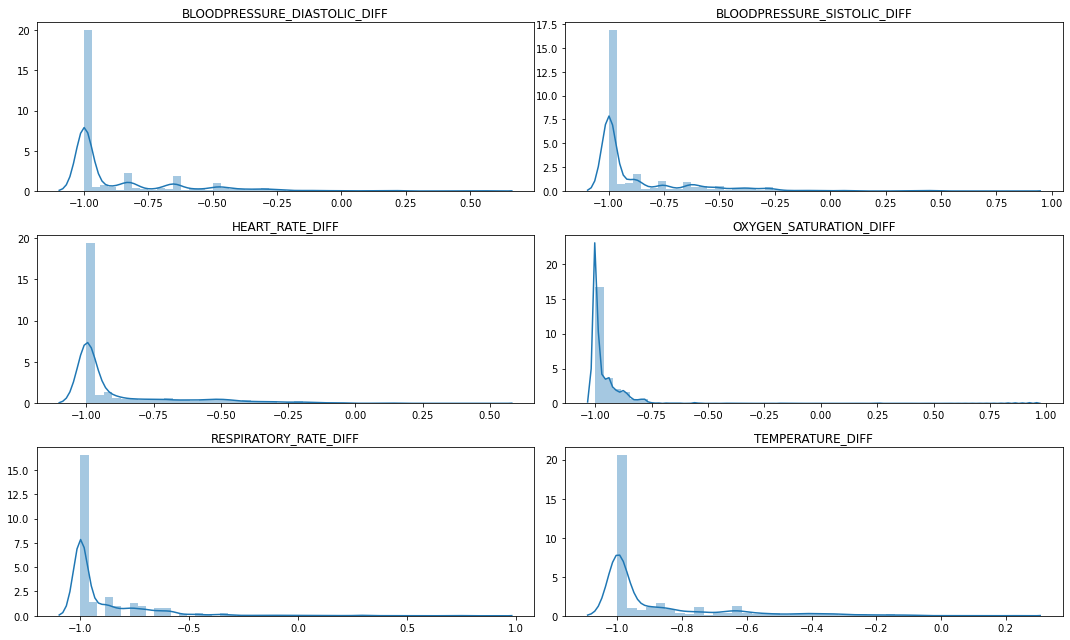

In [38]:
#DIFF
plot_by_cluster(data, time_variant_groups, 'DIFF')

For the *DIFF* cluster, we can see the feature groups behave in a very similar way. All of the present most values close to *-1*. This is not good indication in terms of whether the related features can provide meaningfull information to our predictive model. But we are not going to draw conclusions right now.

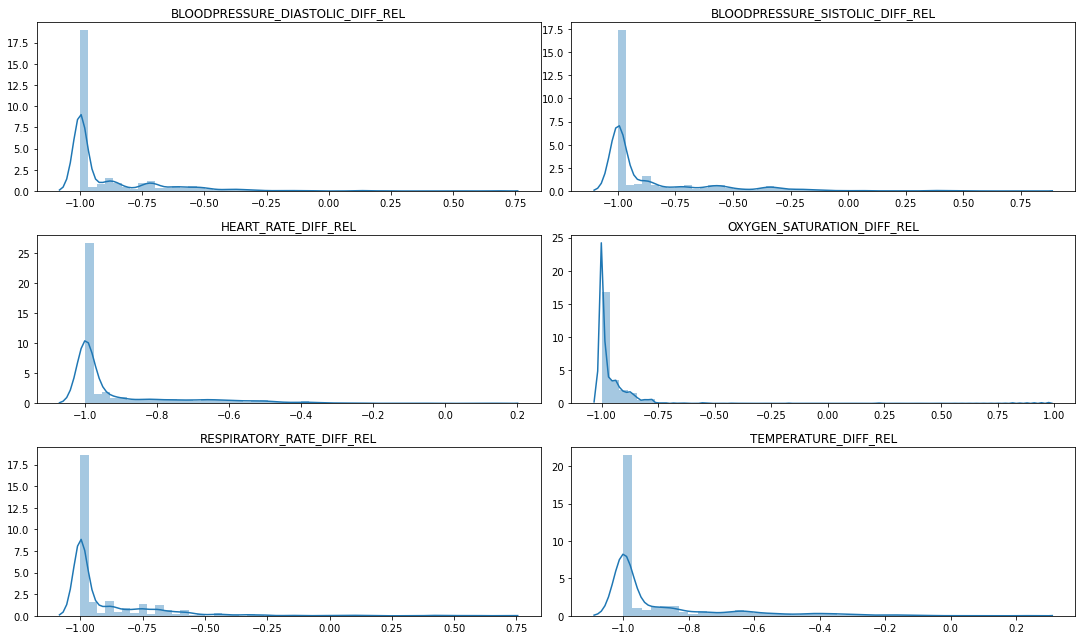

In [39]:
#REL
plot_by_cluster(data, time_variant_groups, 'DIFF_REL')

The observation of the *DIFF_REL* cluster reveals all similar behavior to the previous cluster. This is not surprising, since, as the name suggests, they are just a relative version of the previously shown feature groups.

For the next features, we are goinf to cluster them in a different form, by the health aspect being measured. This is being done because, unlike for the *DIFF* features, we do not expect different measurements to behave very much alike. 

In [40]:
#Identify remaining groups for plotting
reduced_time_variant_groups = \
[x for x in time_variant_groups if ('DIFF' not in x and x not in not_cluster_friendly)]

new_clusters = np.unique(['_'.join(x.split('_')[:-1]) for x in reduced_time_variant_groups])
new_clusters

array(['BLOODPRESSURE_DIASTOLIC', 'BLOODPRESSURE_SISTOLIC', 'HEART_RATE',
       'OXYGEN_SATURATION', 'RESPIRATORY_RATE', 'TEMPERATURE'],
      dtype='<U23')

In [41]:
#Redefine function to plot all feature groups from a cluster
def plot_by_cluster(data, col_groups, cluster_name):
    #Identify groups to be ploted
    groups = [x for x in col_groups if x[:len(cluster_name)] == cluster_name]
    
    #Compute dimensions for subplots
    ncols = 2
    nrows = int(len(groups) / 2) if len(groups) % 2 == 0 else np.floor(len(groups) / 2) + 1

    #Plot groups
    fig, axis = plt.subplots(nrows = nrows, ncols = ncols, figsize = (15, 3*nrows))
    for i, group in enumerate(groups):
        row = int(i / 2)
        col = 0 if i%2 == 0 else 1
        if data[group + '_1'].dtype == np.int64:
            sns.countplot(extract_values_from_group(data, group), ax = axis[row, col]).set_title(group)
        else:
            sns.distplot(extract_values_from_group(data, group), ax = axis[row, col]).set_title(group)
    
    fig.tight_layout()
    return plt.show()

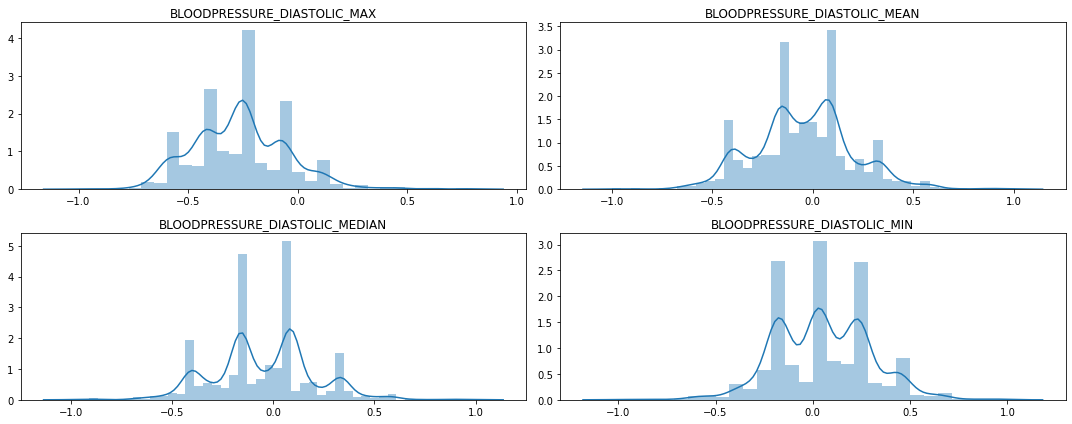

In [42]:
#BLOODPRESSURE_DIASTOLIC'
plot_by_cluster(data, reduced_time_variant_groups, 'BLOODPRESSURE_DIASTOLIC')

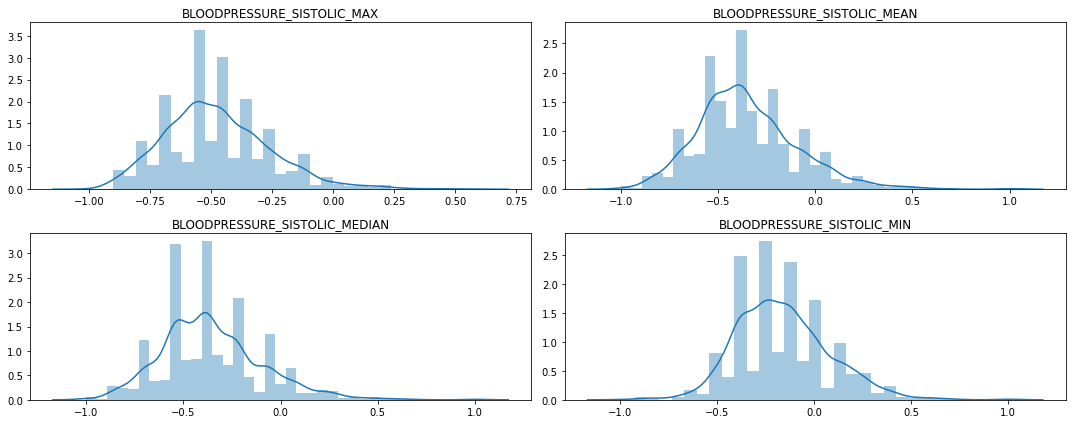

In [43]:
#BLOODPRESSURE_SISTOLIC
plot_by_cluster(data, reduced_time_variant_groups, 'BLOODPRESSURE_SISTOLIC')

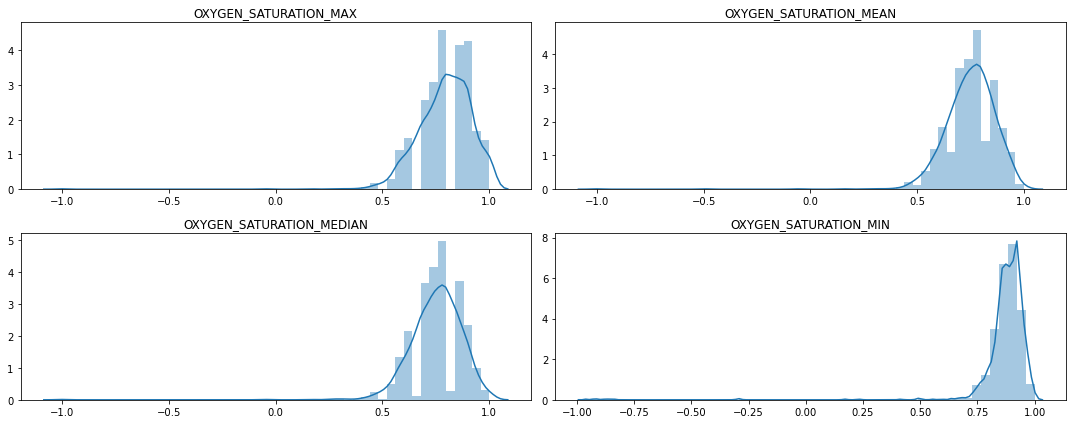

In [44]:
#OXYGEN_SATURATION
plot_by_cluster(data, reduced_time_variant_groups, 'OXYGEN_SATURATION')

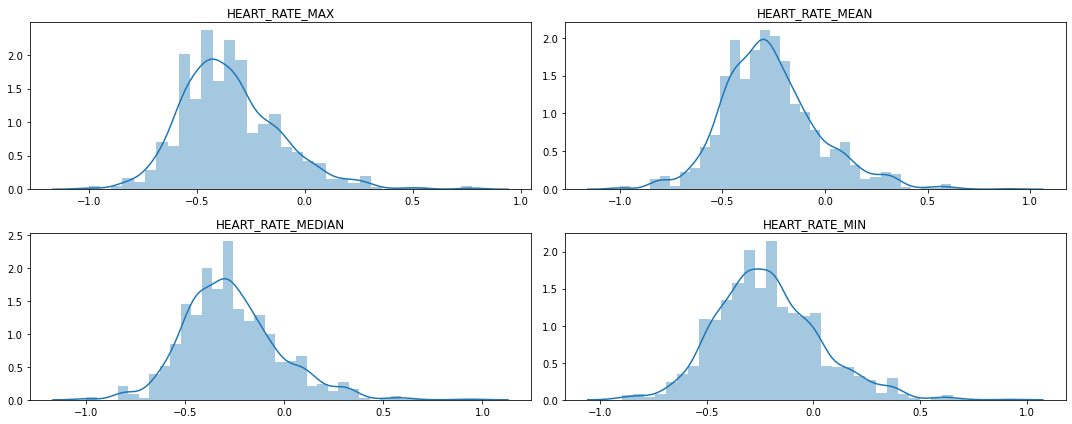

In [45]:
#HEART_RATE
plot_by_cluster(data, reduced_time_variant_groups, 'HEART_RATE')

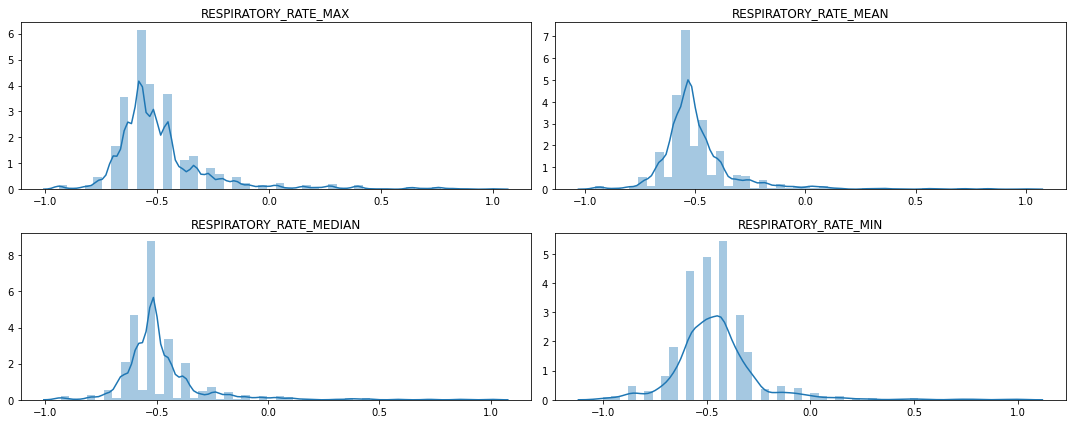

In [46]:
#RESPIRATORY_RATE
plot_by_cluster(data, reduced_time_variant_groups, 'RESPIRATORY_RATE')

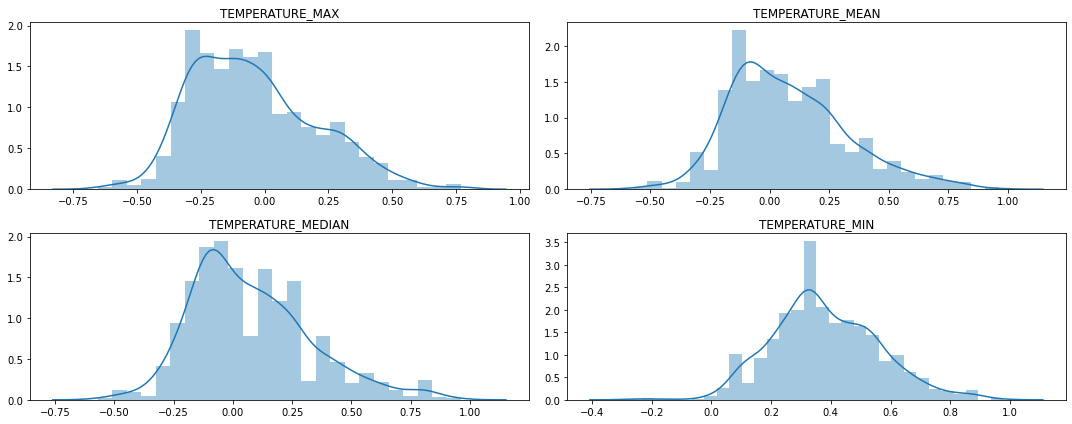

In [47]:
#TEMPERATURE
plot_by_cluster(data, reduced_time_variant_groups, 'TEMPERATURE')

As we suspected, this new way of clustering the feature groups makes a lot more sense. We can clearly see the measurements for each cluster behave in a very similar way, at least when we are not looking at the time component. This leads us to believe something we could have guessed before: the measurements for a single feature cluster are likely correlated, possibly in a strong fashion. We now have a much better sense of how our data behaves. It is then time to look at how the time component affects our analysis.

### 4.2.2. Second Approach: Chronological

In [48]:
#Define function to plot feature group as series of boxplots
def plot_time_series(data, group, axs):
    
    x_vals = []
    y_vals = []
    for n in range(1,6):
        x_vals.extend([n for x in range(len(data))])
        y_vals.extend(data[group + '_' + str(n)])
        
    return sns.boxplot(x = x_vals, y = y_vals, ax = axs)

In [49]:
time_variant_groups

array(['BLOODPRESSURE_DIASTOLIC_DIFF', 'BLOODPRESSURE_DIASTOLIC_DIFF_REL',
       'BLOODPRESSURE_DIASTOLIC_MAX', 'BLOODPRESSURE_DIASTOLIC_MEAN',
       'BLOODPRESSURE_DIASTOLIC_MEDIAN', 'BLOODPRESSURE_DIASTOLIC_MIN',
       'BLOODPRESSURE_SISTOLIC_DIFF', 'BLOODPRESSURE_SISTOLIC_DIFF_REL',
       'BLOODPRESSURE_SISTOLIC_MAX', 'BLOODPRESSURE_SISTOLIC_MEAN',
       'BLOODPRESSURE_SISTOLIC_MEDIAN', 'BLOODPRESSURE_SISTOLIC_MIN',
       'DISEASE GROUPING 1', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3',
       'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'DISEASE GROUPING 6',
       'HEART_RATE_DIFF', 'HEART_RATE_DIFF_REL', 'HEART_RATE_MAX',
       'HEART_RATE_MEAN', 'HEART_RATE_MEDIAN', 'HEART_RATE_MIN',
       'IMMUNOCOMPROMISED', 'OTHER', 'OXYGEN_SATURATION_DIFF',
       'OXYGEN_SATURATION_DIFF_REL', 'OXYGEN_SATURATION_MAX',
       'OXYGEN_SATURATION_MEAN', 'OXYGEN_SATURATION_MEDIAN',
       'OXYGEN_SATURATION_MIN', 'RESPIRATORY_RATE_DIFF',
       'RESPIRATORY_RATE_DIFF_REL', 'RESPIRATORY_RA

In [50]:
#Define function to plot the time series in clusters of feature groups
def plot_time_series_cluster(data, cluster_name):
    groups = [x for x in time_variant_groups if x[:len(cluster_name)] == cluster_name]
    
    ncols = 2
    nrows = int(len(groups) / 2) if len(groups) % 2 == 0 else np.floor(len(groups) / 2) + 1

    #Plot groups
    fig, axis = plt.subplots(nrows = nrows, ncols = ncols, figsize = (15, 3*nrows))
    for i, group in enumerate(groups):
        row = int(i / 2)
        col = 0 if i%2 == 0 else 1
        plot_time_series(data, group, axis[row, col]).set_title(group)
    
    fig.tight_layout()
    return plt.show()

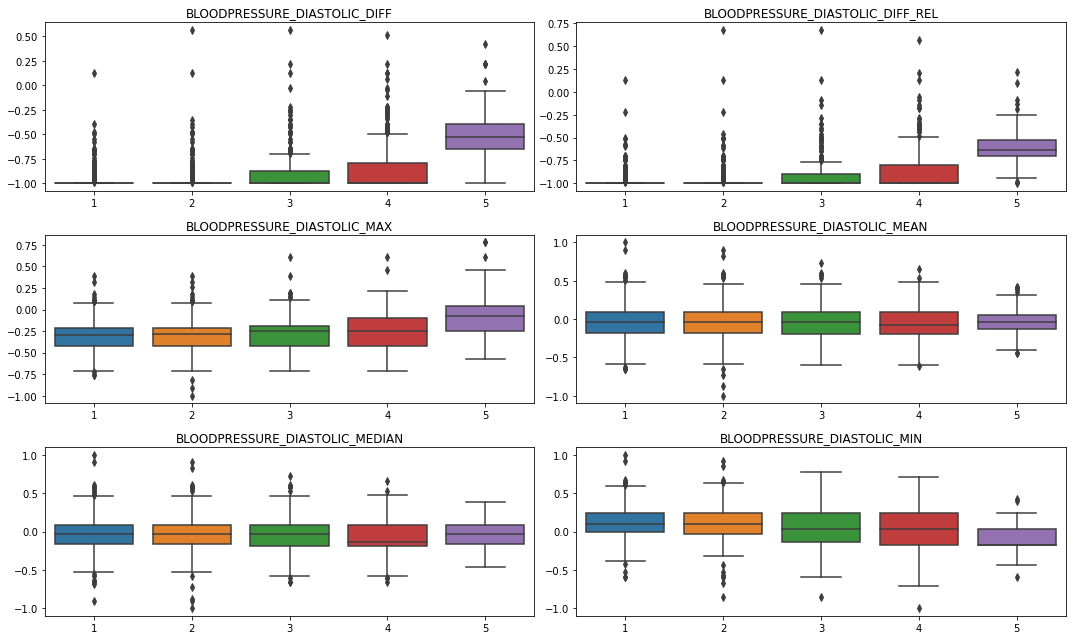

In [51]:
#BLOODPRESSURE_DIASTOLIC
plot_time_series_cluster(data, 'BLOODPRESSURE_DIASTOLIC')

For the *BLOODPRESSURE_DIASTOLIC*, we have the *DIFF* feature groups present the most variation over time. As for the other features, they mostly behave the same from windows 1 through 4, present some relevant change on the last time step. Another interesting aspect are the outliers. For the last four features, they are more frequent in the first two windows.

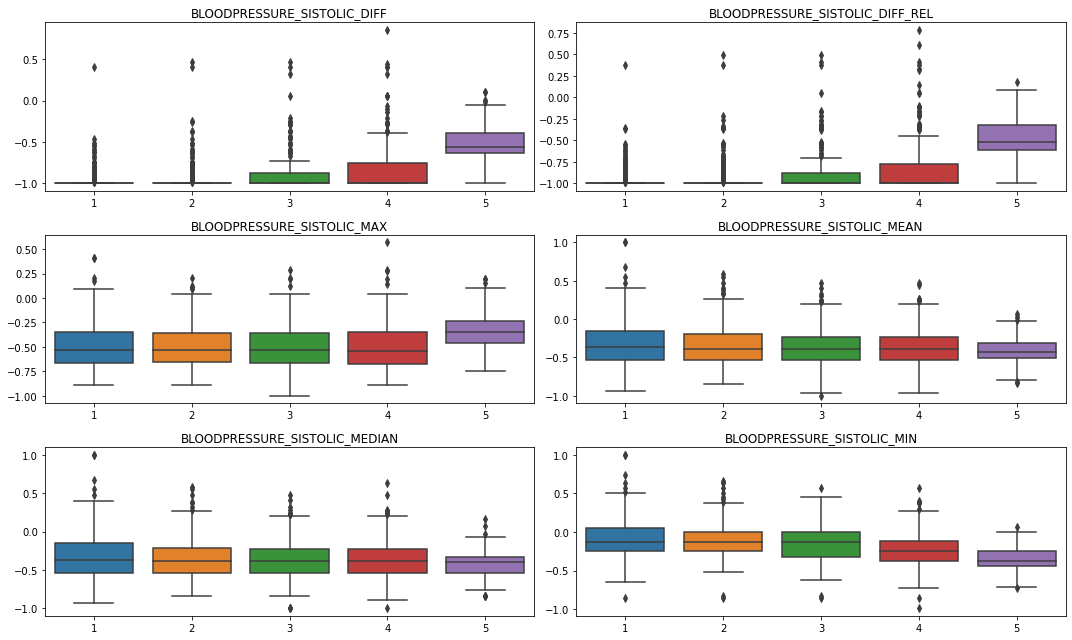

In [52]:
#BLOODPRESSURE_SISTOLIC
plot_time_series_cluster(data, 'BLOODPRESSURE_SISTOLIC')

The *BLOODPRESSURE_SISTOLIC* features present a similar beahavior to their *BLOODPRESSURE_DIASTOLIC* counterparts. The one notable difference is the *BLOODPRESSURE_SISTOLIC_MIN*, which present a gentle but clear trend downward beggining on window 3.

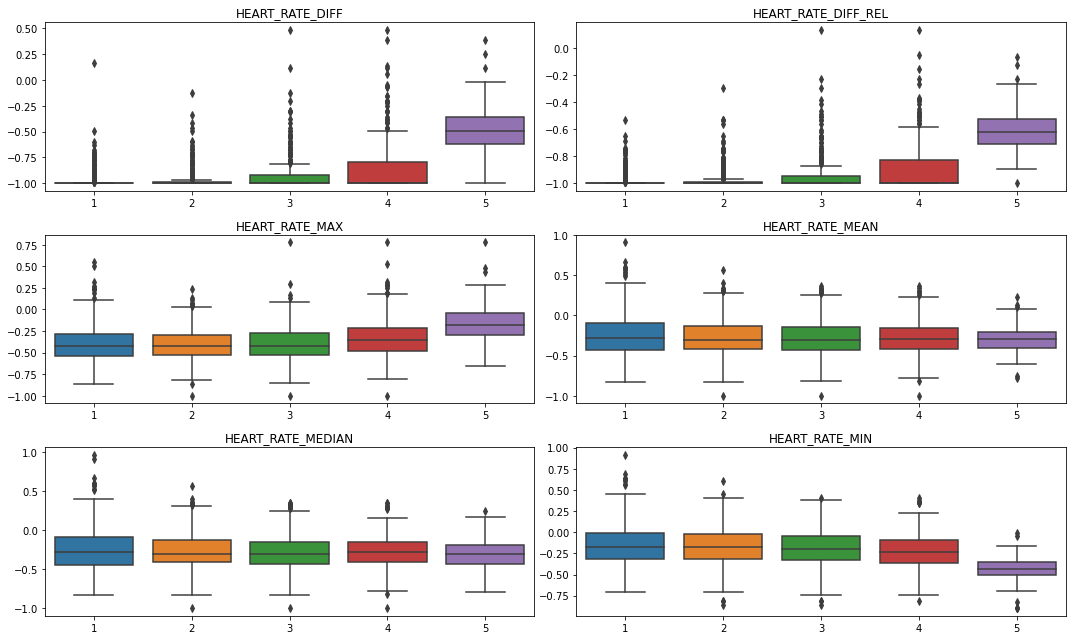

In [53]:
#HEART_RATE
plot_time_series_cluster(data, 'HEART_RATE')

The *HEART_RATE* features, once again behaves in similar way to the previos feature groups. As this pattern seems to common for our data, it is interesting to dig further and understand what it means.

From the point of view of the problem at hand, the best case scenario happens if we could predict whether or not a patient will have to be admitted to the ICU using only its *window 1* measurements. This would mean the medical team would be better prepared and hospital resources usage could become optimal. We then would really like if the *window 1* features behaved very well and presented the smallest amount of outliers. However, this is not the case.

Another important observation is not to take the data from the last windows "too seriously". I am not insinuating the data is wrong. The real issue here is simply the amount of information we have. Remember we are discarding all data obtained after the ICU admission. In the last window, for instance, only around 25% of the data is not missing. This does not necessarily means we are discarding the features, but we have to be carefull when drawing conclusions from datasets this small.

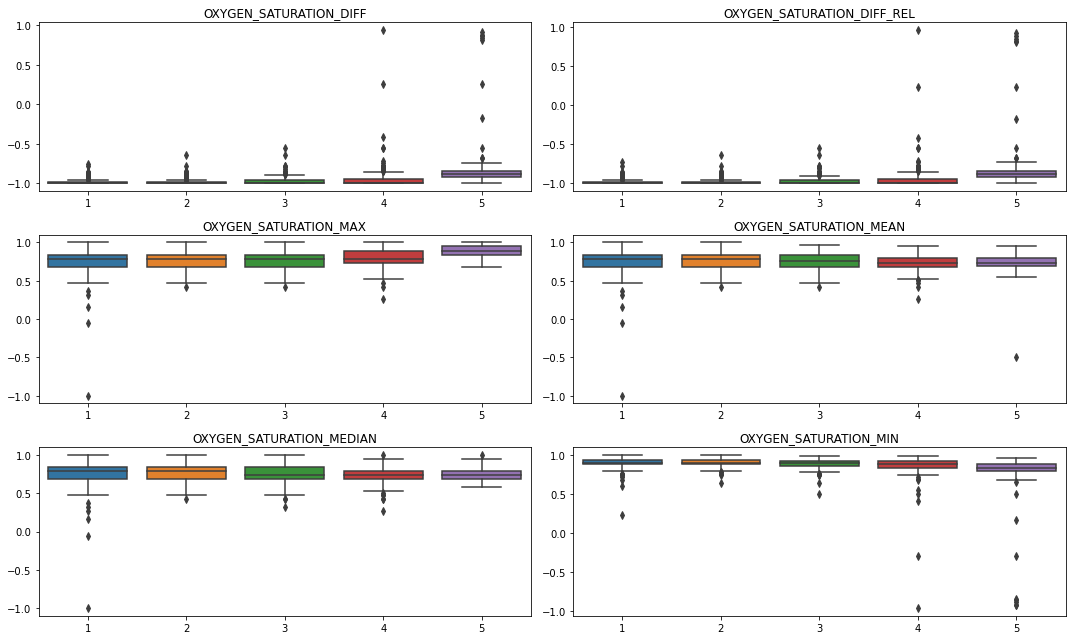

In [54]:
#OXYGEN_SATURATION
plot_time_series_cluster(data, 'OXYGEN_SATURATION')

We now have some very differents plots from the previous feature groups. When it comes to *OXYGEN_SATURATION*, the data distribution is much more narrow. Additionally, even though the *window 1* measures present a large amount of outliers, it does not seem to exist a window related pattern.

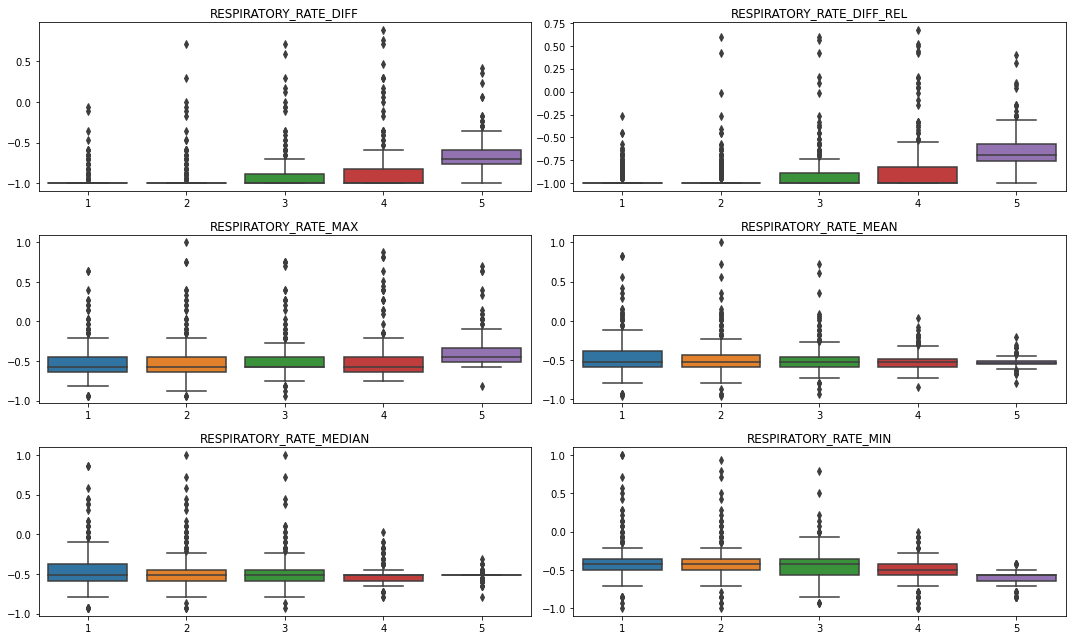

In [55]:
#RESPIRATORY_RATE
plot_time_series_cluster(data, 'RESPIRATORY_RATE')

For the *RESPIRATORY_RATE* attributes, the distributions are once again very narrow. As for the outliers, they are mostly on the windows 1, 2 e 3 features.

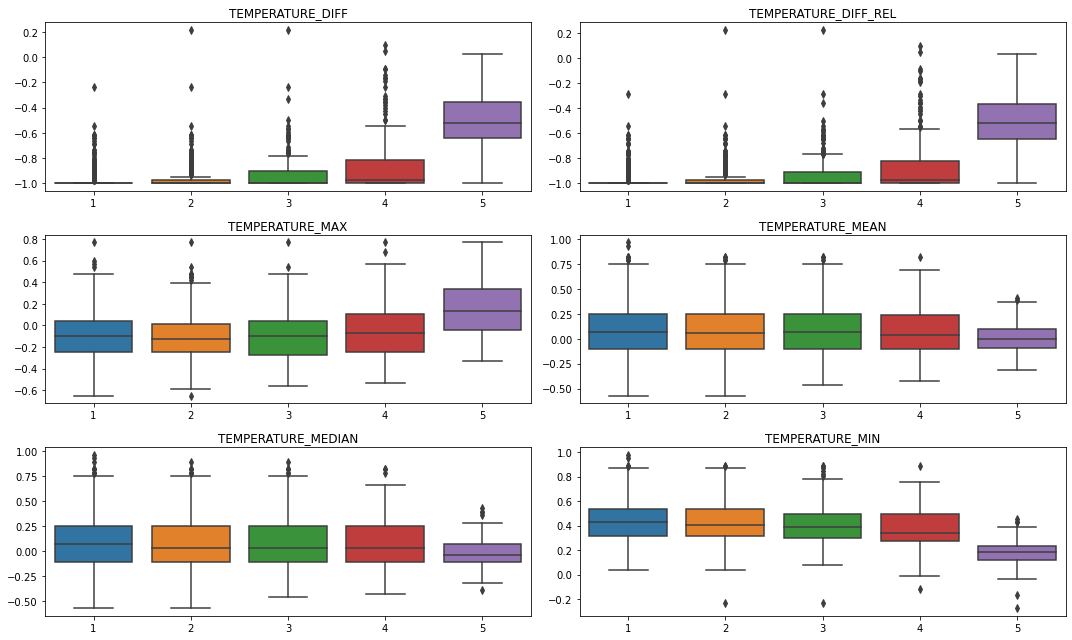

In [56]:
#TEMPERATURE
plot_time_series_cluster(data, 'TEMPERATURE')

Finally, the *TEMPERATURE* features present seem to behave like the the *BLOODPRESSURE* features, preseting a similar behavior until window 3. After that, it is possible to note some relevant change in the data distribution.

Wrapping up this sub-section, we should highlight this exploration will not always gives us mindblowing insights. This is ok. The important thing here is the time we ate spending getting to know the dataset. And, of course, there's plenty more exploratory analysis we can perform.

### 4.2.3. The Remainig Features

There are couple of features we have investigated yet. We are going to analyze from the two previous perspectives at the same time. But first, let's remember who they are.

In [57]:
not_cluster_friendly

['DISEASE GROUPING 1',
 'DISEASE GROUPING 2',
 'DISEASE GROUPING 3',
 'DISEASE GROUPING 4',
 'DISEASE GROUPING 5',
 'DISEASE GROUPING 6',
 'IMMUNOCOMPROMISED',
 'OTHER']

In [58]:
#Redefine the plot_time_series function to use violinplots instead of boxplots
def violinplot_time_series(data, group, axs):
    
    x_vals = []
    y_vals = []
    for n in range(1,6):
        x_vals.extend([n for x in range(len(data))])
        y_vals.extend(data[group + '_' + str(n)])
        
    return sns.violinplot(x = x_vals, y = y_vals, ax = axs)

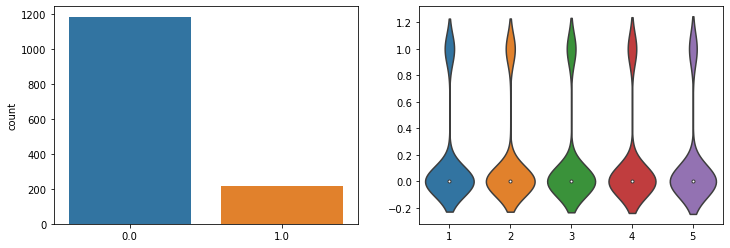

In [59]:
#IMMUNOCOMPROMISED
fig, axis = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))
sns.countplot(extract_values_from_group(data, 'IMMUNOCOMPROMISED'), ax = axis[0])
violinplot_time_series(data, 'IMMUNOCOMPROMISED', axs = axis[1])

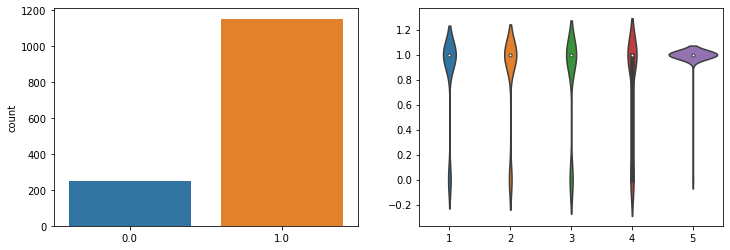

In [60]:
#OTHER
fig, axis = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))
sns.countplot(extract_values_from_group(data, 'OTHER'), ax = axis[0])
violinplot_time_series(data, 'OTHER', axs = axis[1])

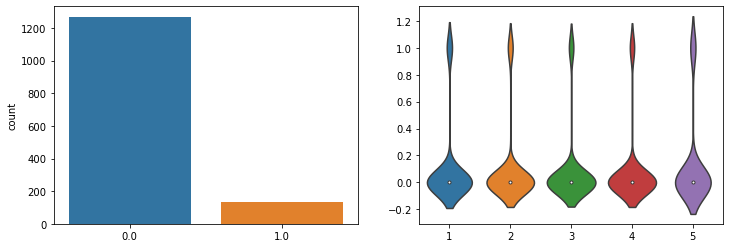

In [61]:
#DISEASE GROUPING 1
fig, axis = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))
sns.countplot(extract_values_from_group(data, 'DISEASE GROUPING 1'), ax = axis[0])
violinplot_time_series(data, 'DISEASE GROUPING 1', axs = axis[1])

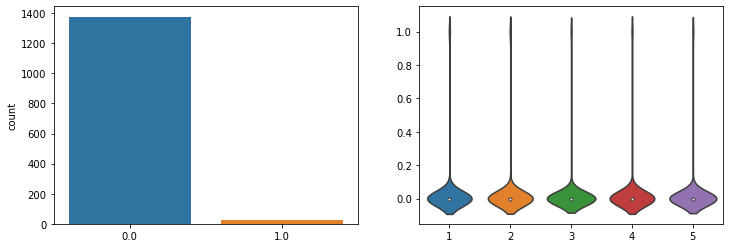

In [62]:
#DISEASE GROUPING 2
fig, axis = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))
sns.countplot(extract_values_from_group(data, 'DISEASE GROUPING 2'), ax = axis[0])
violinplot_time_series(data, 'DISEASE GROUPING 2', axs = axis[1])

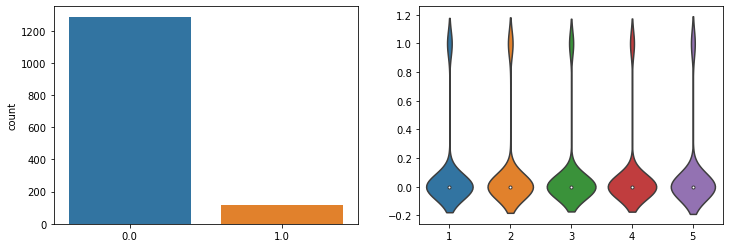

In [63]:
#DISEASE GROUPING 3
fig, axis = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))
sns.countplot(extract_values_from_group(data, 'DISEASE GROUPING 3'), ax = axis[0])
violinplot_time_series(data, 'DISEASE GROUPING 3', axs = axis[1])

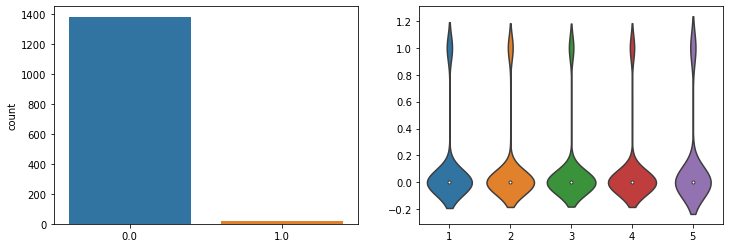

In [64]:
#DISEASE GROUPING 4
fig, axis = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))
sns.countplot(extract_values_from_group(data, 'DISEASE GROUPING 4'), ax = axis[0])
violinplot_time_series(data, 'DISEASE GROUPING 1', axs = axis[1])

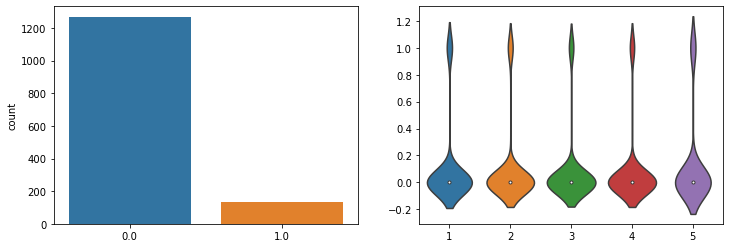

In [65]:
#DISEASE GROUPING 5
fig, axis = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))
sns.countplot(extract_values_from_group(data, 'DISEASE GROUPING 1'), ax = axis[0])
violinplot_time_series(data, 'DISEASE GROUPING 1', axs = axis[1])

All theses features have some thing in common. For instance, they are all binary and very poorly distributed. Additionally, their time window distribution does not seem to change very much, specially if we assume most changes in windows 4 and 5 are due to the increasing number of missing values.

This all leads us to believe these are not actually time variant attributes. If that is the case, we have to remove the redudant features, so they don't get in the way of what we are trying to accomplish. Let's find out if this suspision is true.

In [66]:
#Define function to compute the percentage of records in which the feature value changes over time
def find_feature_value_change(data, group):
    group_cols = [x for x in data.columns if x[:len(group)] == group]
    summarized_data = data.groupby(by = 'PATIENT_VISIT_IDENTIFIER_1').max()[group_cols]
    data_change = summarized_data.max(axis = 1) - summarized_data.min(axis = 1)
    
    return len(data_change[data_change != 0]) / len(data)

In [67]:
#Compute feature time variance
time_change_df = pd.DataFrame(data = [100* find_feature_value_change(data, x) for x in not_cluster_friendly],
                              index = not_cluster_friendly,
                              columns = ['% of records with value change'])

time_change_df.sort_values(by = '% of records with value change', ascending = False)

,% of records with value change
OTHER,24.147727
DISEASE GROUPING 1,2.840909
DISEASE GROUPING 3,1.136364
DISEASE GROUPING 5,1.136364
DISEASE GROUPING 6,1.136364
IMMUNOCOMPROMISED,0.852273
DISEASE GROUPING 2,0.284091
DISEASE GROUPING 4,0.284091


Our hypothesis is turned out to be true, for the most part. Aside from *OTHER*, all the other features present nearly no change over the time windows. Still, these occurrences, however rare, could be strongly correlated to the target. Before we make any decision, it is important to test this possibility.

In [68]:
#Define function to show grafically the correlation between ICU admission and feature change over time
def feature_target_plot(data, group, target):
    group_cols = [x for x in data.columns if x[:len(group)] == group]
    summarized_data = data.groupby(by = 'PATIENT_VISIT_IDENTIFIER_1').max()[group_cols]
    data_change = summarized_data.max(axis = 1) - summarized_data.min(axis = 1)
    
    change_rows = data_change[data_change != 0].index
    no_change_rows = data_change[data_change == 0].index
    
    bot = [0, 0]
    for value in data[target].unique():
        y_vals = [len(data[data[target] == value].filter(change_rows, axis = 'index')) / len(change_rows),
                  len(data[data[target] == value].filter(no_change_rows, axis = 'index')) / len(no_change_rows)]
        x_vals = ['Change', 'No Change']
        
        plt.bar(x_vals, y_vals, bottom = bot, color = np.random.rand(1,3))
        bot = [x + y for x, y in zip(bot, y_vals)]
    
    plt.legend(data[target].unique(), title = target)
    
    return plt.show()

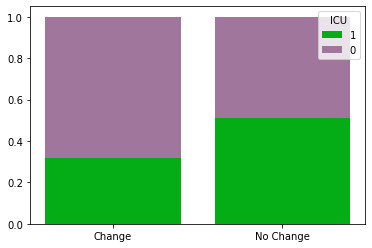

In [69]:
#OTHER
feature_target_plot(data, 'OTHER', 'ICU')

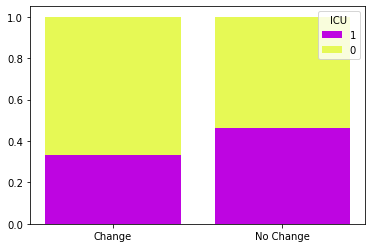

In [70]:
#IMMUNOCOMPROMISED
feature_target_plot(data, 'IMMUNOCOMPROMISED', 'ICU')

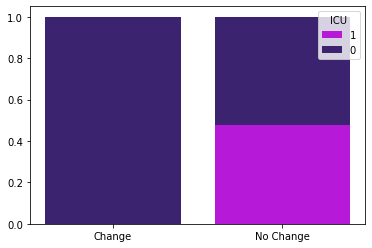

In [71]:
#DISEASE GROUPING 1
feature_target_plot(data, 'DISEASE GROUPING 1', 'ICU')

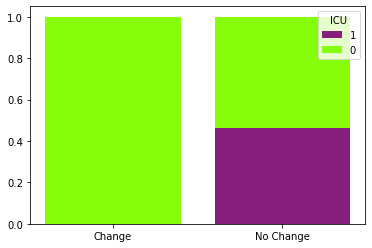

In [72]:
#DISEASE GROUPING 2
feature_target_plot(data, 'DISEASE GROUPING 2', 'ICU')

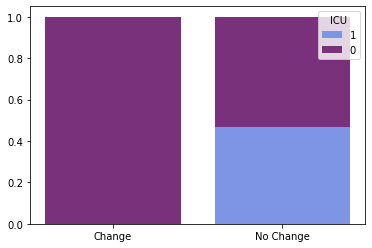

In [73]:
#DISEASE GROUPING 3
feature_target_plot(data, 'DISEASE GROUPING 3', 'ICU')

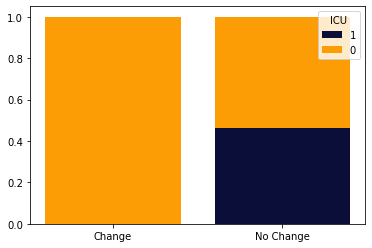

In [74]:
#DISEASE GROUPING 4
feature_target_plot(data, 'DISEASE GROUPING 4', 'ICU')

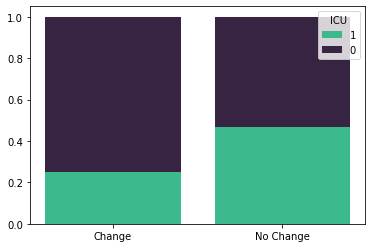

In [75]:
#DISEASE GROUPING 5
feature_target_plot(data, 'DISEASE GROUPING 5', 'ICU')

Some very interesting facts arise from these simple plots. The two most revealing are:

* For the *DESEASE GROUPING* 1 through 4 features, whenever the value changes over time, the patient does not go to the ICU.
* The *OTHER* attribute, the one with the most change over time, presents a relevant change in ICU admission likelyhood.

The main conclusion here is we should not discard the time aspect for these features. Additionally we found out the the change over time for these attributes could be use as new attribute for our model. 

# 5. Conclusion

We have completed the first step in our task to create a predictive model for the ICU admission. As this notebook is already too long, we are going to stop right here and start a new one in which our focus will be feature engineering and selection, as well as actually creating the classification model. Both notebooks will be linked, so anyone trying to have the whole picture won't be lost. 

Well, this is it for now. Please comment and let me know how can I improve this notebook.

In [76]:
#Save processed dataset
data.to_csv('first_step_output_data.csv')